<a href="https://colab.research.google.com/github/srujanm111/energy-analytics/blob/main/FaceMaskSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Insert Title/Intro Here

Runtime Configurations

In [ ]:
run_image_processing = False

Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint

In [ ]:
base_path = '/content/drive/MyDrive/CS378/'
input_path = base_path + 'masked_faces/'
segmap_path = base_path + 'segmentation_masks/'
processed_path = base_path + 'processed_images.txt'
pkl_path = base_path + 'pkl/'
input_pkl_path = pkl_path + 'inputs'
segmap_pkl_path = pkl_path + 'labels'

Global Variables

In [ ]:
# Will be initialized after image processing
num_images = 0

Process Masked Faces and Segmentation Maps

In [ ]:
processed_images_file = open(processed_path, 'r')

inputs = []
segmaps = []

def process_inputs():
  for i, image_name in enumerate(processed_images_file):
    input_image = np.array(Image.open(input_path + image_name[0:-1]))
    segmap_image = np.array(Image.open(segmap_path + image_name[0:-1]).convert("L"))
    inputs.append(input_image)
    segmaps.append(segmap_image)
    
    if i != 0 and i % 50 == 0:
      print(f'{i} ', end='')

  print()


  for i, map in enumerate(segmaps):
    for j, row in enumerate(map):
      for k, num in enumerate(row):
        if num < 128:
          segmaps[i][j][k] = 0
        else:
          segmaps[i][j][k] = 1
      
    if i != 0 and i % 50 == 0:
      print(f'{i} ', end='')

  print()

  with open(input_pkl_path, 'wb') as f:
    pkl.dump(inputs, f)
  
  with open(segmap_pkl_path, 'wb') as f:
    pkl.dump(segmaps, f)

In [ ]:
if run_image_processing:
  process_inputs()
else:
  with open(input_pkl_path, 'rb') as f:
    inputs = pkl.load(f)
  with open(segmap_pkl_path, 'rb') as f:
    segmaps = pkl.load(f)

# Convert input images and segmentation maps to numpy arrays
num_images = len(inputs)
inputs = np.array(inputs)
segmaps = np.array(segmaps)

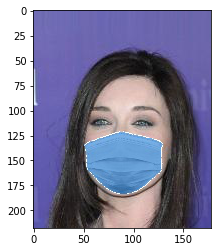

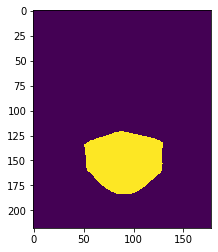

In [ ]:
rand_index = randint(0, num_images)
plt.imshow(inputs[rand_index] / 255)
plt.show()

plt.imshow(segmaps[rand_index] / 255)
plt.show()

Create Dataset

In [ ]:
labels = tf.one_hot(segmaps, 3)
inputs = tf.convert_to_tensor(inputs)

# 60:20:20 Split
train_end = (num_images * 3) // 5
valid_end = (num_images // 5) + train_end

train_data = tf.data.Dataset.from_tensors((inputs[:train_end], labels[:train_end]))
valid_data = tf.data.Dataset.from_tensors((inputs[train_end:valid_end], labels[train_end:valid_end]))
test_data = tf.data.Dataset.from_tensors((inputs[valid_end:], labels[valid_end:]))

Create Model

In [ ]:
conv_depth = 64

model = tf.keras.models.Sequential ([
  # Double Convolution 3 -> 64
  tf.keras.layers.Conv2D(filters=conv_depth, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2D(filters=conv_depth, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  # Double Convolution 64 -> 128
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters=conv_depth*2, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2D(filters=conv_depth*2, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  # Double Convolution 128 -> 256
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters=conv_depth*4, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2D(filters=conv_depth*4, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  # Double Convolution 256 -> 512
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters=conv_depth*8, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2D(filters=conv_depth*8, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  # Double Convolution 512 -> 1024
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters=conv_depth*16, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2D(filters=conv_depth*16, kernel_size=3, padding=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  # Double Convolution 1024 -> 512
  

])

TypeError: ignored